# Mid category detection_using_New_Algo_1

1) The grayscale image - Gaussian Filter - Local Thresholding - Rescaling of Intensity (Intensity stretching) <BR>
2) A Histogram-based threshold, known as Ridler-Calvard method results in intensities that separate the image into two groups of pixels, where the threshold intensity is midway between the mean intensities of these groups. <br>
3) Morphological operations - removing of islands of noise, removing of holes in objects <br>
4) DB Scan is done to cluster the image into different groups <br>
5) GroupVertices are generated for each group and the different groups are marked using Convex hulls<br>

It is observed that lots of small hulls are generated because of the large number of groups generated by the Convex Hull.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import path

from skimage import io
from skimage import transform
#from skimage import segmentation
from skimage import filters
#from skimage import morphology
from skimage import measure
from skimage import util

from sklearn import cluster

from scipy.spatial import ConvexHull

import os



In [2]:
from ipywidgets import interactive
import ipywidgets as widgets

import numpy as np
from matplotlib import pyplot as plt

from skimage import io
from skimage import util
from skimage import filters
from skimage import morphology
from skimage import measure
from skimage import exposure

from sklearn import cluster

In [3]:
farmWidth = 3.0 # meters
tubenetPerMeter = 10 # meters
scale = 1.0

initSigma = 1
offset = -0.05
finalSigma = 1
min_samples = 5

sigma=1.0
block_size=41
min_size=128
eps=10
percentile_range = [50,100]

In [4]:
def read(imgFile,invert=False):
    img = io.imread(imgFile,as_gray=True)
    img = util.img_as_float(img)
    if invert:
        img = util.invert(img)    
    
    img_x, img_y = img.shape
    return img

def readRGB(imgFile):
    rgbimg = io.imread(imgFile)
    return rgbimg

def rescale(img,scale):
    if img is not None:
        scale = np.float(scale)
        img_rs = transform.rescale(img,scale,multichannel=False)
        return img_rs

def plotImg(img,title=None,cmap='gray',figsize=(15,15)):
    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.axis('off')
    ax.imshow(img,cmap=cmap)
    if title:
        ax.set_title(title,fontsize=20)
    plt.show()
    
def init_thresh(img):
    img_g = filters.gaussian(img,sigma=sigma)

    img_g_thresh = filters.threshold_local(img_g,block_size=block_size)

    img_g_applyThresh = (img_g-img_g_thresh)

    img_g_applyThresh = exposure.rescale_intensity(img_g_applyThresh)
    
    return(img_g_applyThresh)

def apply_iso(img_g_applyThresh):

    img_g_applyThresh_iso = filters.threshold_isodata(img_g_applyThresh)
    img_areas = (img_g_applyThresh<img_g_applyThresh_iso)
    
    return(img_areas)

def apply_clrclo(img_areas, min_size):
    img_clr = morphology.remove_small_objects(img_areas,min_size=min_size,connectivity=2)
    img_clo = morphology.remove_small_holes(img_clr,area_threshold=2048,connectivity=2)
    coords = np.asarray(np.where(img_clo == True)).T
    return(coords)

def applyDBSCAN(coords,eps=10, min_samples=5):
    dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    dbscan.fit(coords)
    predictions = dbscan.labels_
    return predictions

def applyConvexHull_Groups(coords,groups):
    groupNums = np.unique(groups)

    groupCoords = []
    groupHulls = []
    #img_rs_groups = []
    groupVertices = []

    for groupNum in groupNums:
        thisCoords = []
        for i in range(len(coords)):
            if groups[i]==groupNum:
                thisCoords.append(coords[i])
        groupCoords.append(np.array(thisCoords))
        thisHull = ConvexHull(thisCoords)
        groupHulls.append(thisHull)
        #thisImg = np.multiply(img, img_groups==groupNum)
        #img_rs_groups.append(thisImg)
        thisVertices = []
        for vertex in thisHull.vertices:
            thisVertices.append([thisCoords[vertex][1],thisCoords[vertex][0]])
        groupVertices.append(np.array(thisVertices))

    return groupCoords,groupHulls,groupVertices

def applyLabels_binImg(img,coords,labels):
    label_mask = np.zeros(img.shape).astype('uint')
    for i in range(len(coords)):
        row,col = coords[i]
        label_mask[row][col]=labels[i]
    return label_mask


def getGroupNums(groups,include0=True):
    if include0:
        return np.unique(groups)
    else:
        all_groups = np.unique(groups)
        index = np.where(all_groups == 1)
        return all_groups[index[0][0]:]


def plotRGBImg_GroupsRS(rgbimg,groups,groupNums,groupVertices,scale, index, fmt='k-',linewidth=1,annotate=True):
    fig, ax = plt.subplots(1,1,figsize=(15, 15))
    ax.axis('off')
    ax.imshow(rgbimg)
    for groupNum in groupNums:
        ax.fill(groupVertices[groupNum][:,0]/scale,
                groupVertices[groupNum][:,1]/scale,
                fmt,linewidth=linewidth,fill=False)
        if annotate:
            ax.annotate(groupNum,xy=(groupVertices[groupNum][0][0]/scale,
                                     groupVertices[groupNum][0][1]/scale))
    filename = 'img'+str(index)+'.png'
    path = '/Users/praneeth/Downloads/Image Processing/Srideep_to_Praneeth_files/Bigger_basket/word_by_word_image3_output/'+filename

    plt.savefig(path)
    
    plt.show()      
    
    


In [5]:
folder = '/Users/praneeth/Downloads/Image Processing/Srideep_to_Praneeth_files/Bigger_basket/images_from_video'

In [13]:
index = 0

In [16]:
filename = 'DRONE_TRANSECT_AR_16SEP19 09.png'

In [17]:

imgFile = os.path.join(folder,filename)
img = read(imgFile)
imgrgb = readRGB(imgFile)
img_g_applyThresh = init_thresh(img)
img_areas = apply_iso(img_g_applyThresh)
coords = apply_clrclo(img_areas, min_size)
groups = applyDBSCAN(coords, eps=eps, min_samples=min_samples)
groupCoords,groupHulls,groupVertices = applyConvexHull_Groups(coords,groups)
groupLabel_Mask = applyLabels_binImg(img,coords,groups)
groupNums = getGroupNums(groups,include0=True)
print(index)


0


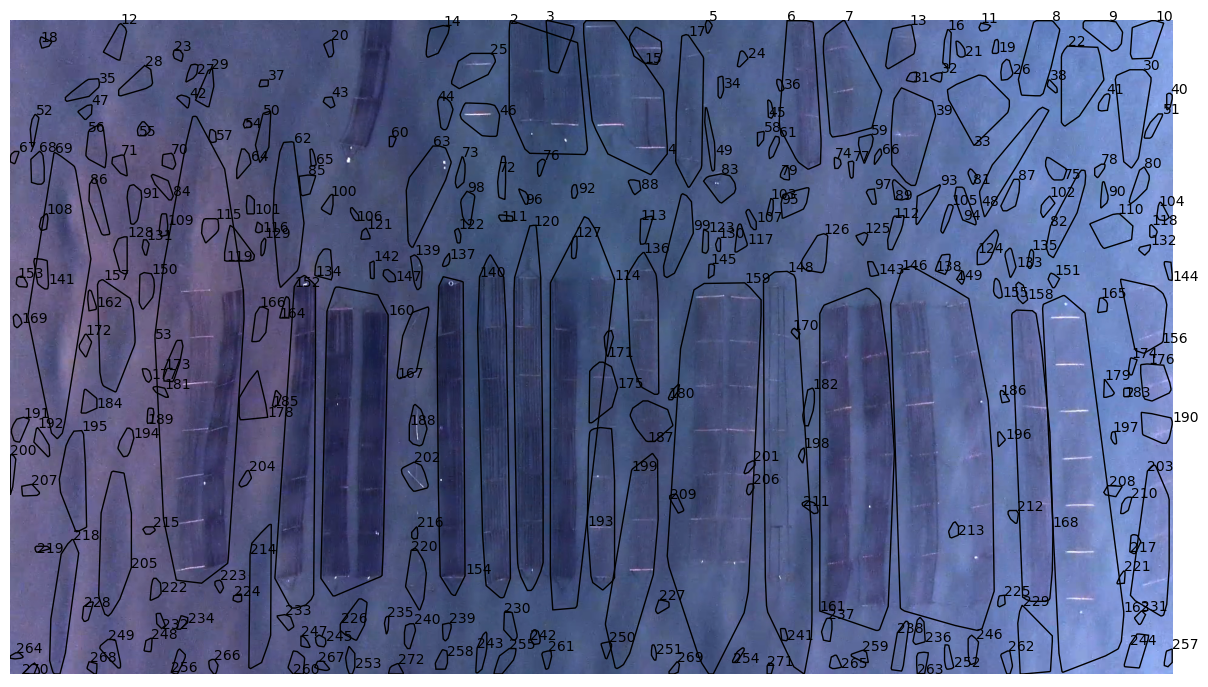

In [18]:
plotRGBImg_GroupsRS(imgrgb,groups,groupNums[2:],groupVertices,scale,index,annotate=True)
